# Simulating future prices using Monte Carlo Methods

In [1]:
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

## Example: PYPL ('2022-01-01 to today)

In [2]:
today = datetime.today().strftime('%Y-%m-%d')

ticker = yf.Ticker("PYPL")
df = ticker.history(start='2020-01-01', end=today, rounding=True)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,109.47,111.21,109.28,110.75,7418800,0,0
2020-01-03,109.49,110.42,108.76,108.76,7098300,0,0
2020-01-06,107.57,110.22,107.44,110.17,6764500,0,0
2020-01-07,111.50,111.56,109.53,109.67,6898700,0,0
2020-01-08,110.40,112.64,109.82,111.82,8293600,0,0
...,...,...,...,...,...,...,...
2022-06-13,76.03,78.13,73.46,73.72,19674400,0,0
2022-06-14,74.30,75.08,71.46,72.46,19289300,0,0
2022-06-15,73.47,77.10,72.39,75.83,17165600,0,0


In [3]:
def prepare_data(ticker):
    """
    import data via yfinance
    
    Parameters
    ----------
    ticker : string
        name of ticker (e.g. "AAPL")
    """
    
    today = datetime.today().strftime('%Y-%m-%d')
    data = yf.Ticker(ticker)
    df = data.history(start='2020-01-01', end=today, rounding=True)
    return df

In [4]:
pypl = prepare_data("PYPL")
pypl.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-13,76.03,78.13,73.46,73.72,19674400,0,0
2022-06-14,74.30,75.08,71.46,72.46,19289300,0,0
2022-06-15,73.47,77.10,72.39,75.83,17165600,0,0
2022-06-16,73.33,74.07,70.71,71.23,14404300,0,0
2022-06-17,71.33,73.66,70.47,72.90,17143600,0,0


In [5]:
pypl['return'] = (pypl['Close'] - pypl['Open']) / pypl['Open']

mu = (pypl.iloc[-1]['Close'] - pypl.iloc[0]['Close']) / pypl.iloc[0]['Close']
std = pypl['return'].std()
print(pypl.index[-1])
print(mu, std)

2022-06-17 00:00:00
-0.3417607223476297 0.023807098326015685


## Sample Simulation

Initial price: $72.9


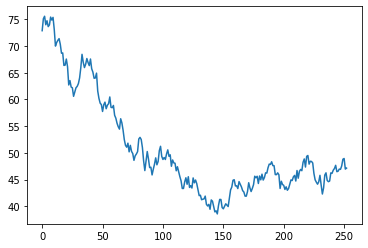

In [6]:
T = 252 # for 252 trading days
S0 = pypl.iloc[-1]['Close'] # current closing price
muS = mu/len(pypl) #muS = mu*dT = mu* (1/total_time)
sigma = std

S_pos = [S0]
print(f"Initial price: ${S0}")

Z = np.random.normal(0,1, size = T)

for t in range(0, T):
    S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
    
plt.plot(S_pos)

In [7]:
pypl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 621 entries, 2020-01-02 to 2022-06-17
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          621 non-null    float64
 1   High          621 non-null    float64
 2   Low           621 non-null    float64
 3   Close         621 non-null    float64
 4   Volume        621 non-null    int64  
 5   Dividends     621 non-null    int64  
 6   Stock Splits  621 non-null    int64  
 7   return        621 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 43.7 KB


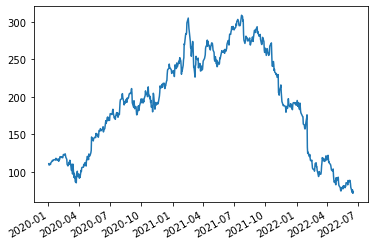

In [8]:
# time series of PYPL
fig = plt.figure()
plt.plot(pypl['Close'])
fig.autofmt_xdate()

## MC Simulation - 1000 trials

$$\Delta S_t =  \mu S_t\Delta t + \sigma S_t * Z_t = S_t (\mu \Delta t + \sigma Z_t)$$

$$S_{t+1} = S_{t} + S_t (\mu \Delta t + \sigma Z_t)$$

Future stock price is current stock price plus some drift $\mu$ with some volatility $Z_t$.

63.64237205181117


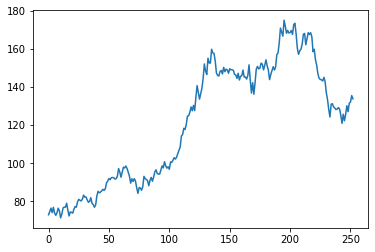

In [9]:
mu = (pypl.iloc[-1]['Close'] - pypl.iloc[0]['Close']) /  pypl.iloc[0]['Close']
std = pypl['return'].std()

T = 252 # 1 trading year
S0 = pypl.iloc[-1]['Close'] # current closing price
muS = mu/len(pypl) #muS = mu*dT = mu* (1/total_time)
sigma = std
final_points = []
returns = []

for sim in range(5000):
    S_pos = [S0]
    Z = np.random.normal(0,1, size = T)
    
    for t in range(0, T):
        S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
    final_points.append(S_pos[-1])
    returns.append((S_pos[-1]-S0)/S0) # Final endpoint vs initial for every simulation
    
print(np.average(final_points))
plt.plot(S_pos) # sample simulation

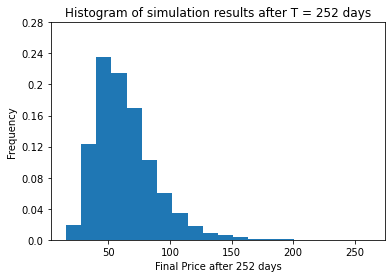

In [10]:
plt.figure()
plt.hist(final_points, bins=20) # Density = True does not work
plt.xlabel("Final Price after 252 days")
plt.title("Histogram of simulation results after T = 252 days")
plt.ylabel("Frequency")

locs, _ = plt.yticks() 
plt.yticks(locs, np.round(locs/len(final_points),3));

# log-normal prices, matches theory

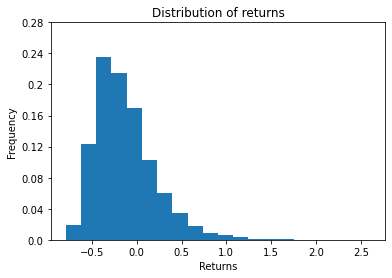

In [11]:
plt.figure()
plt.hist(returns, bins=20)
plt.xlabel("Returns")
plt.title("Distribution of returns")
plt.ylabel("Frequency")

locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/len(returns),3)); 

# linear combination of simulated results, makes sense

# Formulas for simulations for any ticker

In [12]:
### FUNCTIONS FOR PLOTTING AND SIMULATING ###

def prepare_data(ticker, beg='2020-01-01', last=datetime.today().strftime('%Y-%m-%d')):
    """
    Import data via yfinance, defaulted to begin from '2020-01-01' to the most recent market day
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    beg : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    last : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    
    Returns
    -------
    df : DataFrame
        dataframe of historical daily prices from ticker
    """
    
    #today = datetime.today().strftime('%Y-%m-%d')
    data = yf.Ticker(ticker)
    df = data.history(start=beg, end=last, rounding=True)
    
    print()
    print(f"TICKER: {ticker}")
    print(f"Current price: ${df.iloc[-1]['Close']}")
    print(f"Initial price: ${df.iloc[0]['Close']}")
    print("---------------------------------------------")
    
    return df

def calc_mu_std(ticker_data):
    """
    Calculates mu and std of ticker
    
    Parameters
    ----------
    ticker_data : DataFrame
        dataframe of a stock obtained via prepare_data(ticker)
        
    Returns
    -------
    mu : int
        average return in that time frame
    std : int
        standard deviation of returns
    """
    
    total_time = len(ticker_data)
    ticker_data['return'] = (ticker_data['Close'] - ticker_data['Open']) / ticker_data['Open']
    
    mu = (ticker_data.iloc[-1]['Close'] - ticker_data.iloc[0]['Close']) / ticker_data.iloc[0]['Close'] # return from beginning
    std = ticker_data['return'].std()
    
    print(f"From {str(ticker_data.index[0])[:10]} to {str(ticker_data.index[-1])[:10]}:")
    print(f"    Average return in {total_time} market days is {round(100*mu, 3)}%. \n    Standard deviation of returns during this time period is {round(std, 3)}.")
    
    return mu, std

def plot_ts(ticker_data, ticker):
    """
    Plots time series of stock and histogram of returns
    
    Parameters
    ----------
    ticker_data : DataFrame
        dataframe of a stock obtained via prepare_data(ticker)
    ticker : str
        name of ticker (e.g. "AAPL")
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    # plot time series
    axes[0].plot(ticker_data['Close'])
    axes[0].set_xlabel("Years")
    axes[0].set_ylabel("Price in USD")
    axes[0].set_title(f"Current time series of {ticker}")
    fig.autofmt_xdate()
    
    # plot histogram of returns
    axes[1].hist(ticker_data['return'], bins=20)
    axes[1].set_xlabel("Returns")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Histogram of current returns")
    # Density = True
    locs = axes[1].get_yticks() 
    axes[1].set_yticks(locs);
    axes[1].set_yticklabels(np.round(locs/len(ticker_data['return']),3));
    
    return

def MC_Simulation(mu0, std0, ticker_data, time, N):
    """
    Given ticker, ticker data, how far in the future you want to simulate prices(252 is one trading year), 
    yield results of N simulations
    
    Parameters
    ----------
    mu : int
        average return in that time frame
    std : int
        standard deviation of returns
    ticker_data : DataFrame
        dataframe of a stock obtained via prepare_data(ticker)
    time : int
        number of days user wishes to simulate into the future (252 is one trading year)
    N : int
        number of desired simulations in Monte Carlo methods
        
    Returns
    -------
    final_points : list of int
        list of final prices for each MC simulation 
    """
    
    mu, std = mu0, std0
    T = time
    S0 = ticker_data.iloc[-1]['Close']
    muS = mu/len(ticker_data)
    sigma = std
    final_points = []
    returns = []
    
    print()
    print("---------------------------------------------")
    print(f"Simulating {time} days into the future {N} times...")
    
    # MC simulate N times
    for sim in range(N):
        S_pos = [S0]
        Z = np.random.normal(0,1, size = T)

        for t in range(0, T):
            S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
        final_points.append(S_pos[-1])
    
    # Descriptive statistics for ending points
    average = np.round(np.mean(final_points), 2)
    median = np.round(np.percentile(final_points, 50), 2)
    twentyfive = np.round(np.percentile(final_points, 25), 2)
    seventyfive = np.round(np.percentile(final_points, 75), 2)
    
    print()
    print(f"Average ending price: ${average}  ({round(100*(average-S0)/S0, 2)}%)")
    print(f"Median ending price: ${median}  ({round(100*(median-S0)/S0, 2)}%)")
    print(f"25th percentile of ending price: ${twentyfive}  ({round(100*(twentyfive-S0)/S0, 2)}%)")
    print(f"75th percentile of ending price: ${seventyfive}  ({round(100*(seventyfive-S0)/S0, 2)}%)")
    
    return final_points

def plot_hist(end_points, time, ticker):
    """
    Plots histogram and whisker plot of results given array of final points of simulations
    
    Parameters
    ----------
    end_points : list of int
        list of final prices for each MC simulation 
    time : int
        number of days user wishes to simulate into the future (252 is one trading year)
    ticker : str
        name of ticker (e.g. "AAPL")
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f"Simulation Results: {ticker} ({time} days)", fontsize=18, y = 1)
    
    # plot histogram
    axes[0].hist(end_points, bins=20)
    axes[0].set_xlabel("Ending Price")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Histogram of future prices")
    # show density of histogram
    locs = axes[0].get_yticks() 
    axes[0].set_yticks(locs);
    axes[0].set_yticklabels(np.round(locs/len(end_points),3));
  
    # plot boxplot
    sns.boxplot(data=end_points, orient="h", ax=axes[1])
    plt.title("Boxplot of future prices")
    plt.xlabel("Price in USD")
    
    return

### Wrapper functions

In [13]:
def simulate(ticker, time, N, beginning='2020-01-01', ending=datetime.today().strftime('%Y-%m-%d')):
    """
    Wrapper function: simulate and graph results given parameters
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    time : int
        number of days user wishes to simulate into the future (252 is one trading year)
    N : int
        number of desired simulations in Monte Carlo methods
    beginning : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    ending : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    
    data = prepare_data(ticker, beg=beginning, last=ending)
    mu, std = calc_mu_std(data)
    plot_ts(data, ticker)
    results = MC_Simulation(mu, std, data, time, N)
    plot_hist(results, time, ticker)
    
    return

In [14]:
def compare_times(ticker, time1, time2, N, beginning='2020-01-01', ending=datetime.today().strftime('%Y-%m-%d')):
    """
    Wrapper function: simulate and graph results given two different time frames and other parameters.
    Compares predicted future performance of the same stock for two time frames. 
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    time1 : int
        first number of days user wishes to simulate into the future (252 is one trading year)
    time2 : int
        second number of days user wishes to simulate into the future, different from time1
    N : int
        number of desired simulations in Monte Carlo methods
    beginning : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    ending : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    
    data = prepare_data(ticker, beg=beginning, last=ending)
    mu, std = calc_mu_std(data)
    plot_ts(data, ticker)
    # first time
    results = MC_Simulation(mu, std, data, time1, N)
    plot_hist(results, time1, ticker)
    
    #second time
    results = MC_Simulation(mu, std, data, time2, N)
    plot_hist(results, time2, ticker)
    
    return

In [15]:
def compare_stocks(ticker1, ticker2, time, N, beginning='2020-01-01', ending=datetime.today().strftime('%Y-%m-%d')):
    """
    Wrapper function: comparing simulated prices for two different stocks, ticker1 and ticker2.
    Good for comparing correlated stocks (e.g. PEP and KO).
    
    Parameters
    ----------
    ticker1 : str
        name of first ticker (e.g. "AAPL")
    ticker2 : str
        name of second ticker
    time : int
        number of days user wishes to simulate into the future (252 is one trading year)
    N : int
        number of desired simulations in Monte Carlo methods
    beginning : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    ending : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    
    #first stock
    data = prepare_data(ticker1, beg=beginning, last=ending)
    mu, std = calc_mu_std(data)
    results = MC_Simulation(mu, std, data, time, N)
    plot_hist(results, time, ticker1)
    
    print()
    print("-----------------------------------------------------------------------------")
    
    #second stock
    data2 = prepare_data(ticker2, beg=beginning, last=ending)
    mu, std = calc_mu_std(data2)
    results = MC_Simulation(mu, std, data2, time, N)
    plot_hist(results, time, ticker2)
    
    return

# Simulations


TICKER: SQ
Current price: $114.52
Initial price: $61.06
---------------------------------------------
From 2020-04-20 to 2022-04-20:
    Average return in 506 market days is 87.553%. 
    Standard deviation of returns during this time period is 0.034.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $176.01  (53.69%)
Median ending price: $151.14  (31.98%)
25th percentile of ending price: $104.99  (-8.32%)
75th percentile of ending price: $218.68  (90.95%)


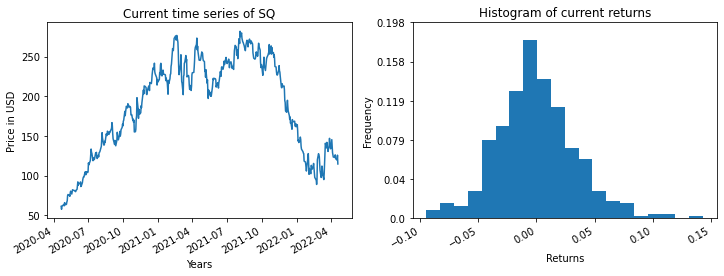

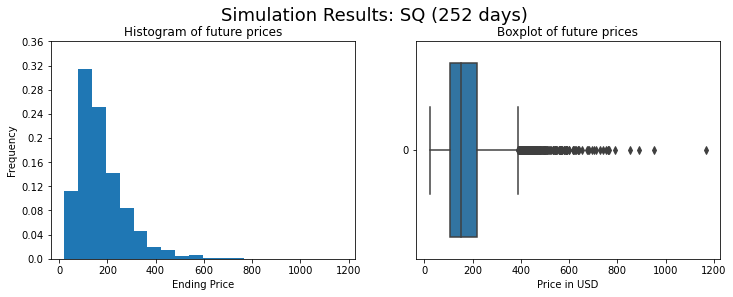

In [16]:
# args: ticker, time, #simulations
simulate("SQ", 252, 5000, beginning='2020-04-20', ending='2022-04-21')


TICKER: MA
Current price: $310.69
Initial price: $299.48
---------------------------------------------
From 2020-01-02 to 2022-06-17:
    Average return in 621 market days is 3.743%. 
    Standard deviation of returns during this time period is 0.018.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $316.14  (1.75%)
Median ending price: $304.33  (-2.05%)
25th percentile of ending price: $253.48  (-18.41%)
75th percentile of ending price: $366.02  (17.81%)

---------------------------------------------
Simulating 500 days into the future 5000 times...

Average ending price: $320.54  (3.17%)
Median ending price: $297.09  (-4.38%)
25th percentile of ending price: $225.37  (-27.46%)
75th percentile of ending price: $388.81  (25.14%)


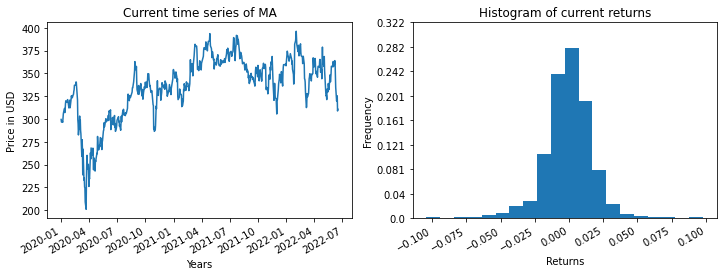

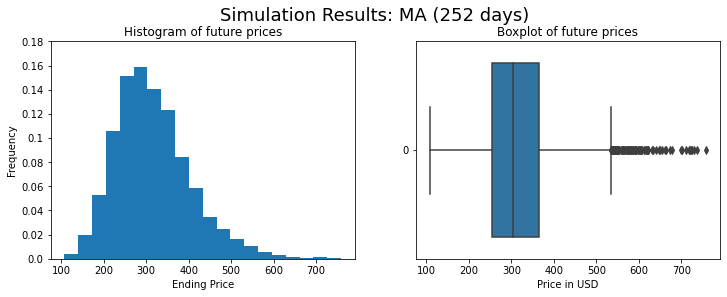

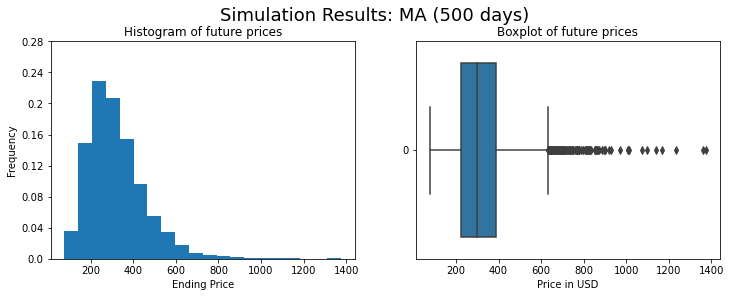

In [17]:
# args: ticker, time 1, time 2, #simulations
compare_times("MA", 252, 500, 5000)


TICKER: SPY
Current price: $442.8
Initial price: $277.65
---------------------------------------------
From 2020-04-27 to 2022-04-20:
    Average return in 501 market days is 59.481%. 
    Standard deviation of returns during this time period is 0.009.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $595.81  (34.56%)
Median ending price: $589.58  (33.15%)
25th percentile of ending price: $538.51  (21.61%)
75th percentile of ending price: $647.61  (46.25%)

-----------------------------------------------------------------------------

TICKER: VOO
Current price: $408.71
Initial price: $255.92
---------------------------------------------
From 2020-04-27 to 2022-04-20:
    Average return in 501 market days is 59.702%. 
    Standard deviation of returns during this time period is 0.009.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $551.42  (34.

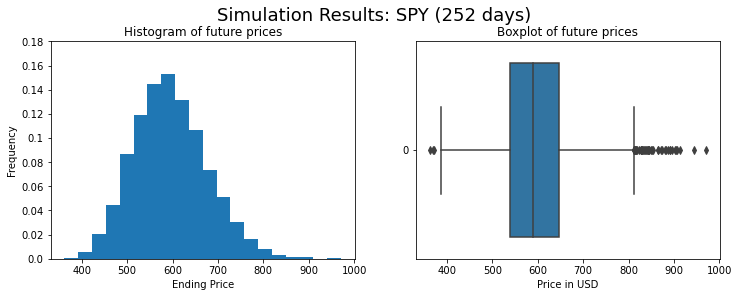

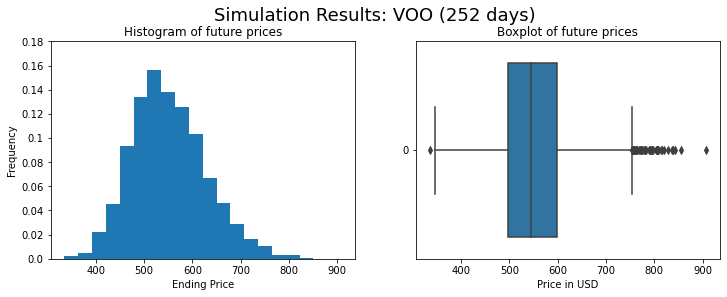

In [18]:
# args: ticker 1, ticker 2, time, #simulations
compare_stocks("SPY", "VOO", 252, 5000, beginning='2020-04-25', ending='2022-04-21')